Final results using trained models on 700k dataset.

In [1]:
import os
import sys
import random

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from PIL import Image
from torchvision import models, transforms
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score, balanced_accuracy_score, top_k_accuracy_score

import tensorboard

sys.path.append('/home/jko/ice3d-ml-paper')
from models.mlp_regression import MLPRegression
from models.mlp_classification import MLPClassification
from models.resnet18_regression import ResNet18Regression
from models.resnet18_classification import ResNet18Classification
from models.cnn_regression import VanillaCNNRegression
from models.cnn_classification import VanillaCNNClassification

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from data.tabular_datamodule import TabularDataModule
from data.tabular_dataset import TabularDataset
from data.single_view_datamodule import SingleViewDataModule
from data.single_view_dataset import SingleViewDataset
from data.stereo_view_datamodule import StereoViewDataModule
from data.stereo_view_dataset import StereoViewDataset
import json
from torchvision.models import ResNet18_Weights

import pickle
import joblib
from sklearn.preprocessing import StandardScaler

# Setup data

In [18]:
# imagery
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
# tabular
tab_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
tab_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
tab_path = os.path.join(tab_dir, tab_file)
tab_stereo_2ds_file = 'ros-tabular-data-stereo-default-2ds-shuffled-subset-700000.parquet'
tab_stereo_2ds_path = os.path.join(tab_dir, tab_stereo_2ds_file)
tab_stereo_phips_file = 'ros-tabular-data-stereo-default-phips-shuffled-subset-700000.parquet'
tab_stereo_phips_path = os.path.join(tab_dir, tab_stereo_phips_file)
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# where to save plots
savedir = './figs/test-results'
os.makedirs(savedir, exist_ok=True)
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

# set up data
features_default = ['aspect_ratio', 'aspect_ratio_elip', 
'extreme_pts', 'contour_area', 'contour_perimeter', 
'area_ratio', 'complexity', 'circularity']
features_stereo = ['aspect_ratio_1', 'aspect_ratio_elip_1', 
'extreme_pts_1', 'contour_area_1', 'contour_perimeter_1', 
'area_ratio_1', 'complexity_1', 'circularity_1',
'aspect_ratio_2', 'aspect_ratio_elip_2', 'extreme_pts_2', 
'contour_area_2', 'contour_perimeter_2', 'area_ratio_2', 
'complexity_2', 'circularity_2']
targets_reg = ['rho_eff', 'sa_eff']
targets_cls = ['n_arms']
batch_size = 128
n_rand = 666
num_workers = 16
def log_transform(x):
    return torch.log(x)
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

# set colors
cmap_reg = 'magma'
cmap_cls = 'Blues'

# global plot parameters 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 14

# define transforms
def get_transforms(data_type, input_channels, task_type):
    transforms = {}
    # Define transforms based on data_type
    if data_type in ['single_view_h5', 'stereo_view_h5']:
        train_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        val_transform = T.Compose([
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        transforms['train'] = train_transform
        transforms['val'] = val_transform
        transforms['test'] = val_transform
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['train_target'] = target_transform
        transforms['val_target'] = target_transform
        transforms['test_target'] = target_transform    
        return transforms
    elif data_type == 'tabular':
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['target'] = target_transform
        return transforms
    else:
        return None
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)

# create dataframe to save metrics for all models
metrics_reg = {}
metrics_cls = {}

# Linear Baseline

## Single view

### Regression

In [3]:
# load data
data_path = os.path.join(tab_dir, tab_file)
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
df_features = df[features_default]
df_targets = df[targets_reg]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_reg_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test)

# create output dataframe
df_out = y_test.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_out['rho_eff_pred'] = y_test_pred[:, 0]
df_out['sa_eff_pred'] = y_test_pred[:, 1]

Note: inputs/outputs not transformed for linear regression.

In [4]:
# compute metrics and save

# Compute RMSE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
rmse_rho = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for rho_eff:", rmse_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
rmse_sa = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for sa_eff:", rmse_sa)

# Compute MAE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
mae_rho = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for rho_eff:", mae_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
mae_sa = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(df_out['rho_eff_truth'], df_out['rho_eff_pred'])
r2_sa = r2_score(df_out['sa_eff_truth'], df_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['lin_default'] = metrics

RMSE for rho_eff: 0.011717135641741455
RMSE for sa_eff: 0.04450787602535065
MAE for rho_eff: 0.09194966778005292
MAE for sa_eff: 0.18482395819671527
R2 for effective density = 0.9313679171196094
R2 for effective surface area = 0.9070072819223418


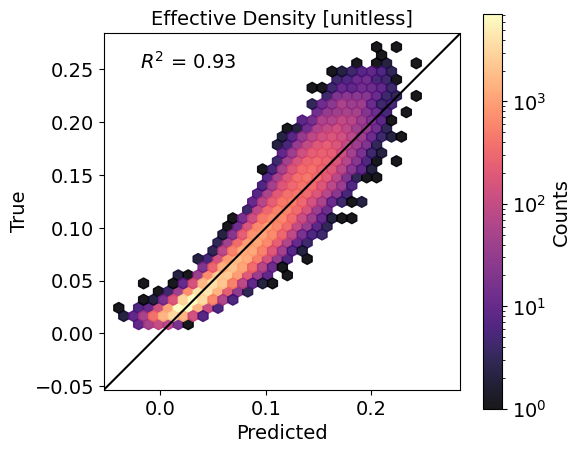

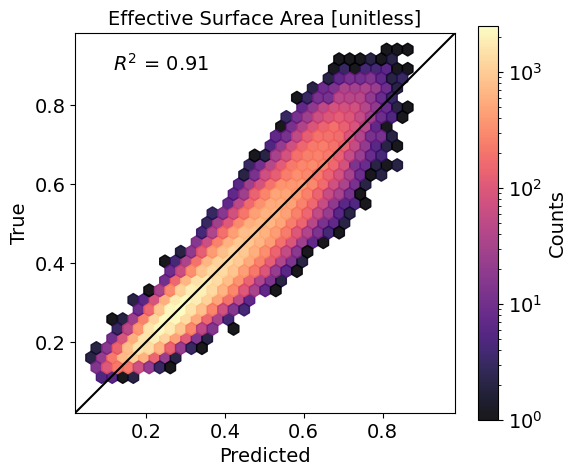

In [19]:
# Create seperate plots for rho_eff and sa_eff

# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    df_out['rho_eff_pred'], df_out['rho_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left')
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'lin_reg_default_scatter_rho.png')
plt.savefig(savepath1, dpi=300)
# plt.close(fig1)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    df_out['sa_eff_pred'], df_out['sa_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left')
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'lin_reg_default_scatter_sa.png')
plt.savefig(savepath2, dpi=300)
# plt.close(fig2)

### Classification

Note: need to apply standard scaler to inputs.

In [20]:
# load data
data_path = os.path.join(tab_dir, tab_file)
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
df_features = df[features_default]
df_targets = df[targets_cls]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# scale inputs 
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_cls_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test_scaled)
y_test_probs = model.predict_proba(X_test_scaled)

In [21]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(y_test, y_test_pred, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
balanced_acc = float(balanced_accuracy_score(y_test, y_test_pred))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(y_test, y_test_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['lin_default'] = metrics
print(metrics)

[0.4475495612112027, 0.4535099665717469, 0.4496892883726443, 0.45350003465983896, 0.901743792916258]


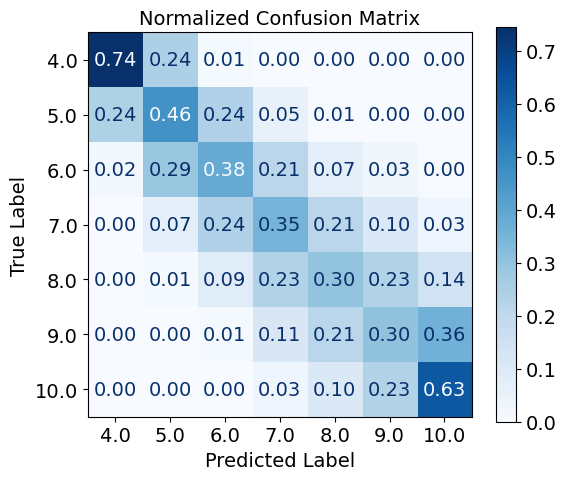

In [26]:
# Extract predictions and targets
preds = y_test_pred
targets = y_test.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = model.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'lin_cls_default_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

## Stereo (2DS)

### Regression

In [27]:
# load data
data_path = os.path.join(tab_dir, tab_stereo_2ds_file)
df = pd.read_parquet(data_path)
df_features = df[features_stereo]
df_targets = df[targets_reg]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_reg_stereo_2ds_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test)

# create output dataframe
df_out = y_test.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_out['rho_eff_pred'] = y_test_pred[:, 0]
df_out['sa_eff_pred'] = y_test_pred[:, 1]

Note: inputs/outputs not transformed for linear regression.

In [28]:
# compute metrics and save

# Compute RMSE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
rmse_rho = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for rho_eff:", rmse_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
rmse_sa = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for sa_eff:", rmse_sa)

# Compute MAE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
mae_rho = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for rho_eff:", mae_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
mae_sa = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(df_out['rho_eff_truth'], df_out['rho_eff_pred'])
r2_sa = r2_score(df_out['sa_eff_truth'], df_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['lin_stereo_2ds'] = metrics

RMSE for rho_eff: 0.009627732215741244
RMSE for sa_eff: 0.03322123272920497
MAE for rho_eff: 0.08373955742513928
MAE for sa_eff: 0.15933996505329268
R2 for effective density = 0.9536625352117107
R2 for effective surface area = 0.9481908234403171


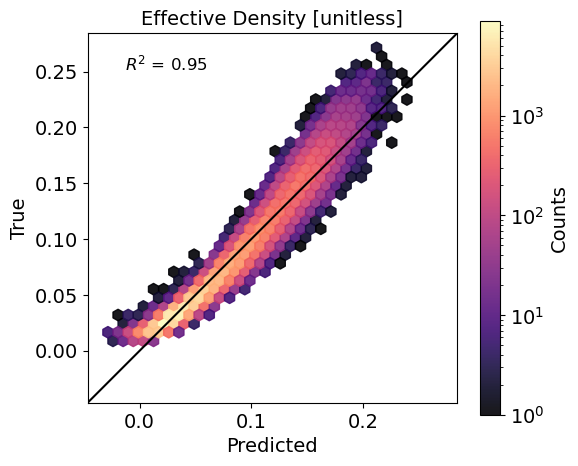

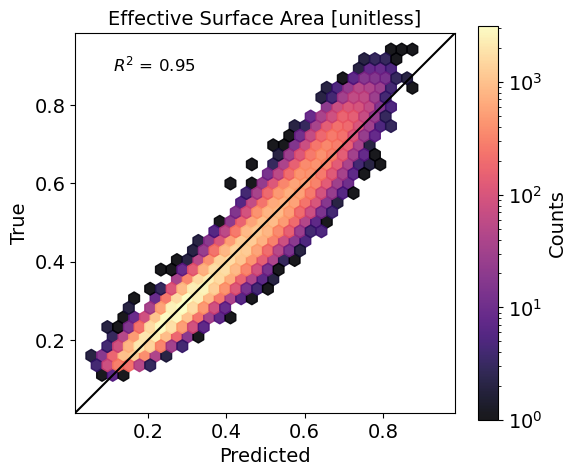

In [30]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    df_out['rho_eff_pred'], df_out['rho_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'lin_reg_stereo_2ds_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    df_out['sa_eff_pred'], df_out['sa_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'lin_reg_stereo_2ds_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

### Classification

In [31]:
# load data
data_path = os.path.join(tab_dir, tab_stereo_2ds_file)
df = pd.read_parquet(data_path)
df_features = df[features_stereo]
df_targets = df[targets_cls]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# scale inputs 
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_cls_stereo_2ds_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test_scaled)
y_test_probs = model.predict_proba(X_test_scaled)

In [32]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(y_test, y_test_pred, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
balanced_acc = float(balanced_accuracy_score(y_test, y_test_pred))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(y_test, y_test_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['lin_stereo_2ds'] = metrics
print(metrics)

[0.5823240729621761, 0.5844991952457596, 0.583282232042069, 0.5844390220391789, 0.9714574146912887]


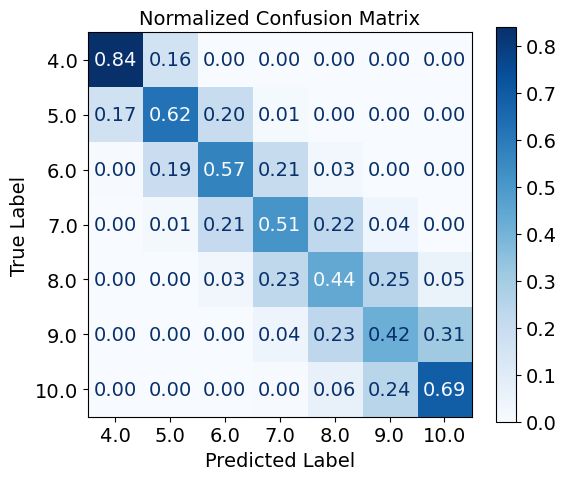

In [33]:
# Extract predictions and targets
preds = y_test_pred
targets = y_test.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = model.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'lin_cls_stereo_2ds_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

## Stereo (PHIPS)

### Regression

In [34]:
# load data
data_path = os.path.join(tab_dir, tab_stereo_phips_file)
df = pd.read_parquet(data_path)
df_features = df[features_stereo]
df_targets = df[targets_reg]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_reg_stereo_phips_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test)

# create output dataframe
df_out = y_test.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_out['rho_eff_pred'] = y_test_pred[:, 0]
df_out['sa_eff_pred'] = y_test_pred[:, 1]

Note: inputs/outputs not transformed for linear regression.

In [35]:
# compute metrics and save

# Compute RMSE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
rmse_rho = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for rho_eff:", rmse_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
rmse_sa = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for sa_eff:", rmse_sa)

# Compute MAE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
mae_rho = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for rho_eff:", mae_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
mae_sa = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(df_out['rho_eff_truth'], df_out['rho_eff_pred'])
r2_sa = r2_score(df_out['sa_eff_truth'], df_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['lin_stereo_phips'] = metrics

RMSE for rho_eff: 0.009921519516915235
RMSE for sa_eff: 0.035027940693077284
MAE for rho_eff: 0.08509859521049697
MAE for sa_eff: 0.1641290584376654
R2 for effective density = 0.9507914411366686
R2 for effective surface area = 0.9424023964837196


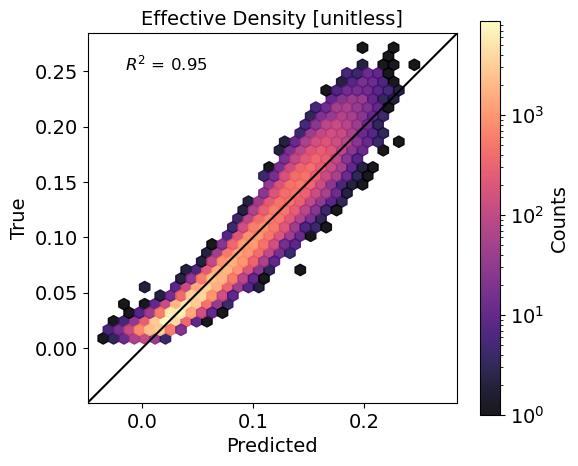

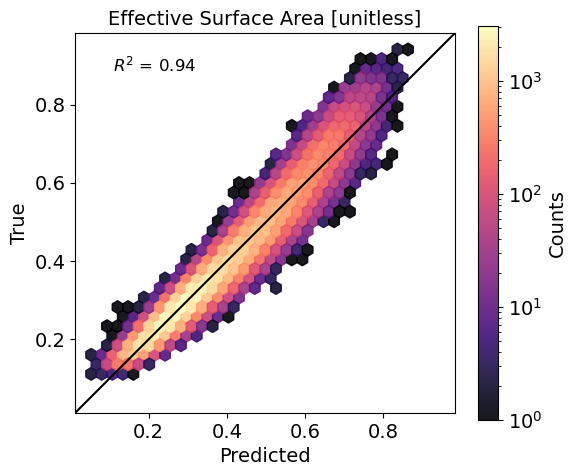

In [36]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    df_out['rho_eff_pred'], df_out['rho_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'lin_reg_stereo_phips_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    df_out['sa_eff_pred'], df_out['sa_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'lin_reg_stereo_phips_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

### Classification

In [37]:
# load data
data_path = os.path.join(tab_dir, tab_stereo_phips_file)
df = pd.read_parquet(data_path)
df_features = df[features_stereo]
df_targets = df[targets_cls]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# scale inputs 
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/lin_cls_stereo_phips_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test_scaled)
y_test_probs = model.predict_proba(X_test_scaled)

In [38]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(y_test, y_test_pred, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
balanced_acc = float(balanced_accuracy_score(y_test, y_test_pred))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(y_test, y_test_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['lin_stereo_phips'] = metrics
print(metrics)

[0.5639549273162886, 0.5684326815935087, 0.5657480640270125, 0.5683815475523564, 0.9671336463462252]


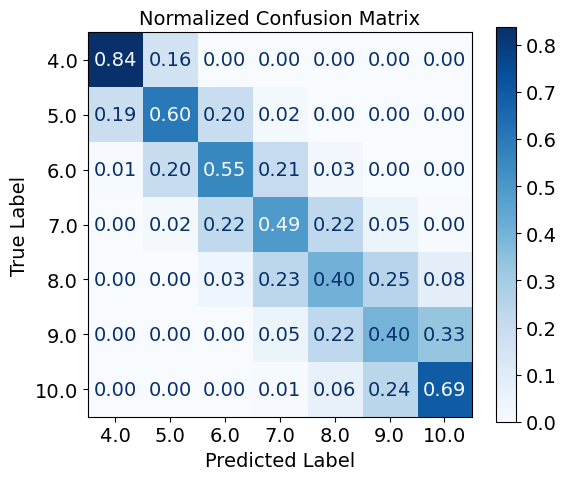

In [39]:
# Extract predictions and targets
preds = y_test_pred
targets = y_test.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = model.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'lin_cls_stereo_phips_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

# Random Forest

## Regression

In [40]:
# load data
data_path = os.path.join(tab_dir, tab_file)
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
df_features = df[features_default]
df_targets = df[targets_reg]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/rf_reg_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test)

# create output dataframe
df_out = y_test.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_out['rho_eff_pred'] = y_test_pred[:, 0]
df_out['sa_eff_pred'] = y_test_pred[:, 1]

Note: inputs/outputs not transformed for rf regression.

In [41]:
# compute metrics and save

# Compute RMSE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
rmse_rho = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for rho_eff:", rmse_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
rmse_sa = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print("RMSE for sa_eff:", rmse_sa)

# Compute MAE
y_true = y_test['rho_eff'].to_numpy()
y_pred = y_test_pred[:, 0]
mae_rho = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for rho_eff:", mae_rho)
y_true = y_test['sa_eff'].to_numpy()
y_pred = y_test_pred[:, 1]
mae_sa = float(np.sqrt(mean_absolute_error(y_true, y_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(df_out['rho_eff_truth'], df_out['rho_eff_pred'])
r2_sa = r2_score(df_out['sa_eff_truth'], df_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['rf_default'] = metrics

RMSE for rho_eff: 0.009677788325068283
RMSE for sa_eff: 0.040968963443442925
MAE for rho_eff: 0.08032469636408379
MAE for sa_eff: 0.17588820603944488
R2 for effective density = 0.9531794509700415
R2 for effective surface area = 0.9212074502656921


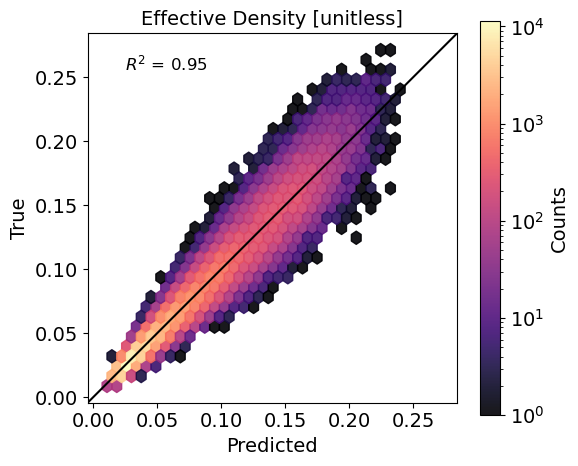

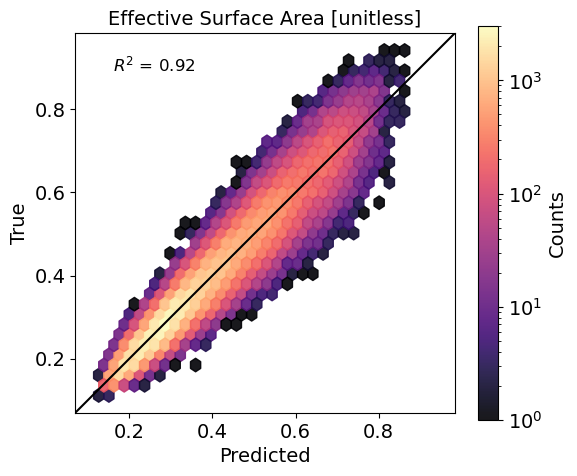

In [42]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    df_out['rho_eff_pred'], df_out['rho_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'rf_reg_default_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    df_out['sa_eff_pred'], df_out['sa_eff_truth'],
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'rf_reg_default_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

## Classification

In [43]:
# load data
data_path = os.path.join(tab_dir, tab_file)
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
df_features = df[features_default]
df_targets = df[targets_cls]
X = df_features
y = df_targets
X_test = df_features.iloc[test_idx]
y_test = df_targets.iloc[test_idx]

# scale inputs 
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# load model 
# NOTE: saved with joblib, need to load with joblib
model_path = '/home/jko/ice3d/models/skl-models/rf_cls_700k_subset.pkl'
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# run inference on test data
y_test_pred = model.predict(X_test_scaled)
y_test_probs = model.predict_proba(X_test_scaled)

In [44]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(y_test, y_test_pred, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
balanced_acc = float(balanced_accuracy_score(y_test, y_test_pred))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(y_test, y_test_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['rf_default'] = metrics
print(metrics)

[0.45030112645366793, 0.4603860915610328, 0.4529909666522818, 0.4603856893183821, 0.9049437624403577]


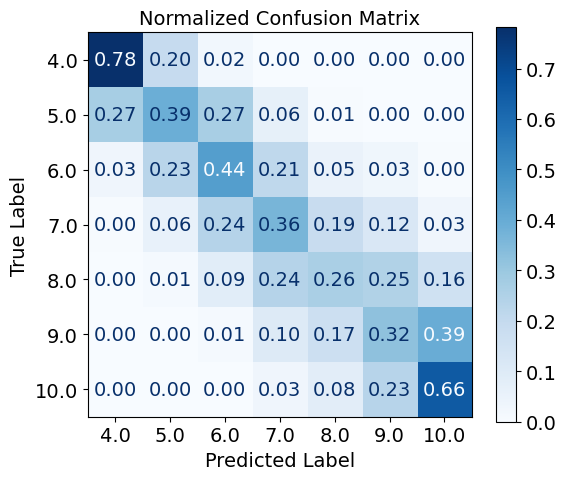

In [45]:
# Extract predictions and targets
preds = y_test_pred
targets = y_test.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = model.classes_.astype(str)  # Get class labels from the classifier
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'rf_cls_default_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

# MLP

## Regression

In [46]:
data_type = 'tabular'
input_channels = 2
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = TabularDataModule(
    data_file=tab_path,
    feature_names=features_default,
    target_names=targets_reg,
    batch_size=batch_size,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=num_workers,
    task_type='regression',
    class_to_idx=None,
    target_transform=transforms['target'],
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()

In [47]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-regression-subset-700k-csv/version_1/checkpoints/model-epoch=46-val_loss=0.0142.ckpt'
model = MLPRegression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_size=8, 
    output_size=2, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

MLPRegression(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

In [48]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# n_batches=10
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        # if i >= n_batches:  # Stop after 20 batches
        #     break
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [49]:
# compute metrics and save
rho_true = all_targets[:, 0]
rho_pred = all_preds[:, 0]
sa_true = all_targets[:, 1]
sa_pred = all_preds[:, 1]
# Compute RMSE
rmse_rho = float(np.sqrt(mean_squared_error(rho_true, rho_pred)))
print("RMSE for rho_eff:", rmse_rho)
rmse_sa = float(np.sqrt(mean_squared_error(sa_true, sa_pred)))
print("RMSE for sa_eff:", rmse_sa)
# Compute MAE
mae_rho = float(np.sqrt(mean_absolute_error(rho_true, rho_pred)))
print("MAE for rho_eff:", mae_rho)
mae_sa = float(np.sqrt(mean_absolute_error(sa_true, sa_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(rho_true, rho_pred)
r2_sa = r2_score(sa_true, sa_pred)
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['mlp_default'] = metrics

RMSE for rho_eff: 0.009557838378355832
RMSE for sa_eff: 0.04066638191453557
MAE for rho_eff: 0.07964097761678965
MAE for sa_eff: 0.17522652304443667
R2 for effective density = 0.9543328881263733
R2 for effective surface area = 0.9223670363426208


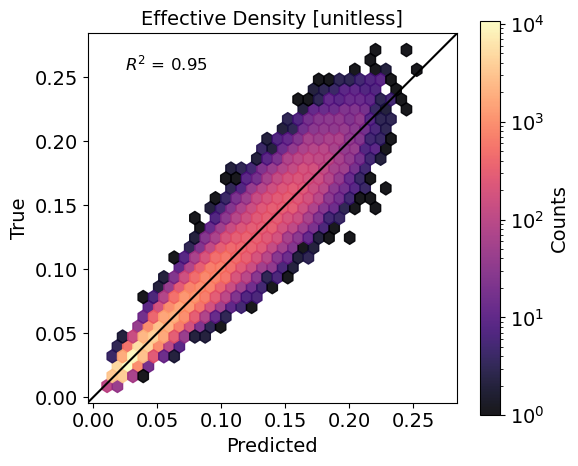

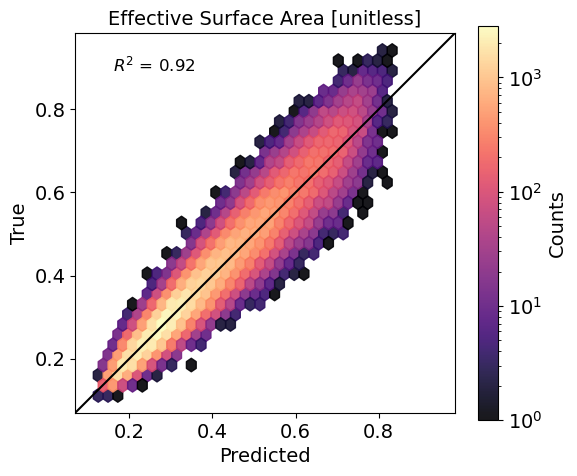

In [50]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    rho_pred, rho_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'mlp_reg_default_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    sa_pred, sa_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'mlp_reg_default_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

## Classification

In [51]:
data_type = 'tabular'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)
dm = TabularDataModule(
    data_file=tab_path,
    feature_names=features_default,
    target_names=targets_cls,
    batch_size=batch_size,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=num_workers,
    task_type='classification',
    class_to_idx=class_to_idx,
    target_transform=transforms['target'],
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()

In [52]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-classification-subset-700k-csv/version_2/checkpoints/model-epoch=41-val_loss=1.1785.ckpt'
model = MLPClassification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_size=8, 
    num_classes=7, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

MLPClassification(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=7, bias=True)
)

In [53]:
loader = dm.test_dataloader()
all_preds = []
all_probs = []
all_targets = []
print_frq = 100
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Get probabilities using softmax
        probs = torch.softmax(preds, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
all_preds = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [54]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(all_targets, all_preds, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
balanced_acc = float(balanced_accuracy_score(all_targets, all_preds))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(all_targets, all_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['mlp_default'] = metrics
print(metrics)

[0.4612405415143054, 0.46878601156179467, 0.4635231907491274, 0.46877345666646525, 0.9088103922819782]


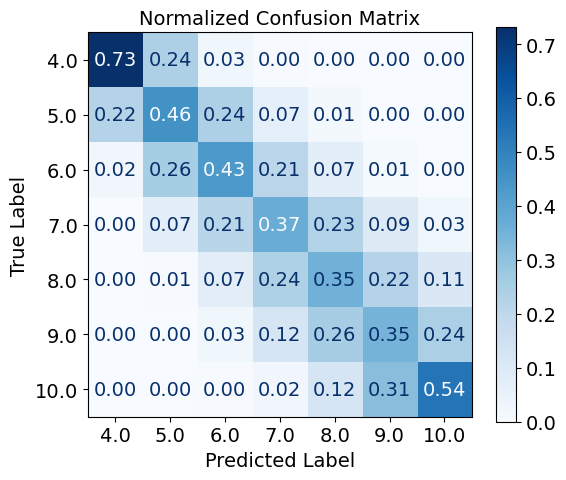

In [55]:
# Extract predictions and targets
preds = all_targets
targets = all_preds

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = list(dm.class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'mlp_cls_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

# CNN

## Regression

In [56]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'single_view_h5'
input_channels = 1
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = SingleViewDataModule(
    hdf_file=hdf_path1,
    target_names=targets_reg,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='regression',
    class_to_idx=None
)
dm.setup()

In [57]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/cnn-regression-subset-700k-csv/version_6/checkpoints/model-epoch=46-val_loss=0.0079.ckpt'
model = VanillaCNNRegression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=1, 
    output_size=2, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

VanillaCNNRegression(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [58]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [59]:
# compute metrics and save
rho_true = all_targets[:, 0]
rho_pred = all_preds[:, 0]
sa_true = all_targets[:, 1]
sa_pred = all_preds[:, 1]
# Compute RMSE
rmse_rho = float(np.sqrt(mean_squared_error(rho_true, rho_pred)))
print("RMSE for rho_eff:", rmse_rho)
rmse_sa = float(np.sqrt(mean_squared_error(sa_true, sa_pred)))
print("RMSE for sa_eff:", rmse_sa)
# Compute MAE
mae_rho = float(np.sqrt(mean_absolute_error(rho_true, rho_pred)))
print("MAE for rho_eff:", mae_rho)
mae_sa = float(np.sqrt(mean_absolute_error(sa_true, sa_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(rho_true, rho_pred)
r2_sa = r2_score(sa_true, sa_pred)
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['cnn_default'] = metrics

RMSE for rho_eff: 0.007281479211969412
RMSE for sa_eff: 0.028530341957358634
MAE for rho_eff: 0.068935919383856
MAE for sa_eff: 0.14529714118636952
R2 for effective density = 0.9734952449798584
R2 for effective surface area = 0.9617889523506165


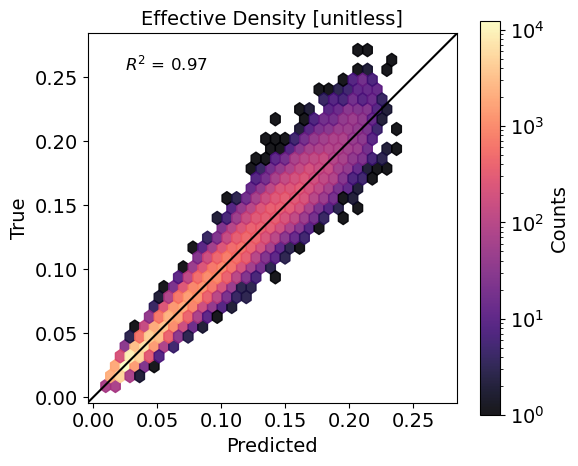

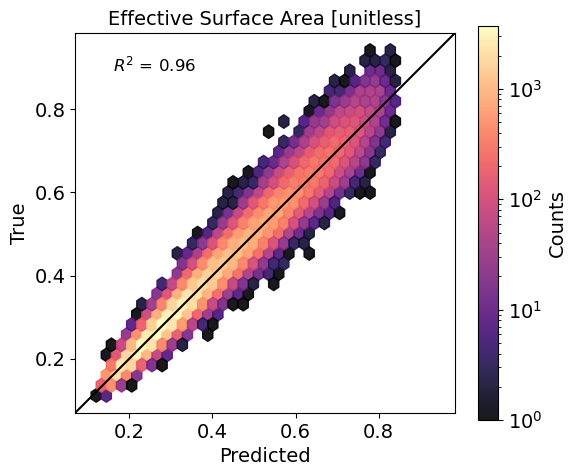

In [60]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    rho_pred, rho_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'cnn_reg_default_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    sa_pred, sa_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'cnn_reg_default_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

## Classification

In [61]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'single_view_h5'
input_channels = 1
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)
dm = SingleViewDataModule(
    hdf_file=hdf_path1,
    target_names=targets_cls,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='classification',
    class_to_idx=class_to_idx
)
dm.setup()

In [62]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/cnn-classification-subset-700k-csv/version_2/checkpoints/model-epoch=45-val_loss=0.6060.ckpt'
model = VanillaCNNClassification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=1, 
    num_classes=7, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

VanillaCNNClassification(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)

In [63]:
loader = dm.test_dataloader()
all_preds = []
all_probs = []
all_targets = []
print_frq = 100
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Get probabilities using softmax
        probs = torch.softmax(preds, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
all_preds = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [64]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(all_targets, all_preds, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
balanced_acc = float(balanced_accuracy_score(all_targets, all_preds))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(all_targets, all_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['cnn_default'] = metrics
print(metrics)

[0.7689039119266587, 0.7640212950352854, 0.7642538294439425, 0.7638557300852267, 0.9970190760087999]


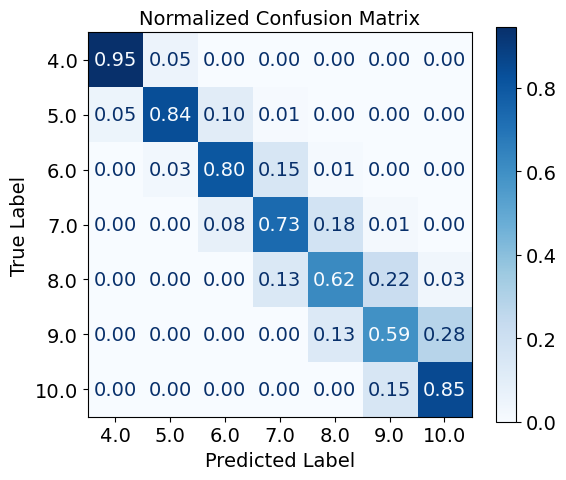

In [65]:
# Extract predictions and targets
preds = all_targets
targets = all_preds

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = list(dm.class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'cnn_cls_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

# Resnet18

## Single View

### Regression

In [66]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'single_view_h5'
input_channels = 1
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = SingleViewDataModule(
    hdf_file=hdf_path1,
    target_names=targets_reg,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='regression',
    class_to_idx=None
)
dm.setup()

In [67]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-regression-subset-700k-csv/version_3/checkpoints/model-epoch=49-val_loss=0.0039.ckpt'
model = ResNet18Regression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=1, 
    output_size=2, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ResNet18Regression(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [68]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [69]:
# compute metrics and save
rho_true = all_targets[:, 0]
rho_pred = all_preds[:, 0]
sa_true = all_targets[:, 1]
sa_pred = all_preds[:, 1]
# Compute RMSE
rmse_rho = float(np.sqrt(mean_squared_error(rho_true, rho_pred)))
print("RMSE for rho_eff:", rmse_rho)
rmse_sa = float(np.sqrt(mean_squared_error(sa_true, sa_pred)))
print("RMSE for sa_eff:", rmse_sa)
# Compute MAE
mae_rho = float(np.sqrt(mean_absolute_error(rho_true, rho_pred)))
print("MAE for rho_eff:", mae_rho)
mae_sa = float(np.sqrt(mean_absolute_error(sa_true, sa_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(rho_true, rho_pred)
r2_sa = r2_score(sa_true, sa_pred)
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['resnet18_default'] = metrics

RMSE for rho_eff: 0.004753214779918458
RMSE for sa_eff: 0.018600166575032984
MAE for rho_eff: 0.05479987978494599
MAE for sa_eff: 0.11506984166169364
R2 for effective density = 0.9887056946754456
R2 for effective surface area = 0.9837591648101807


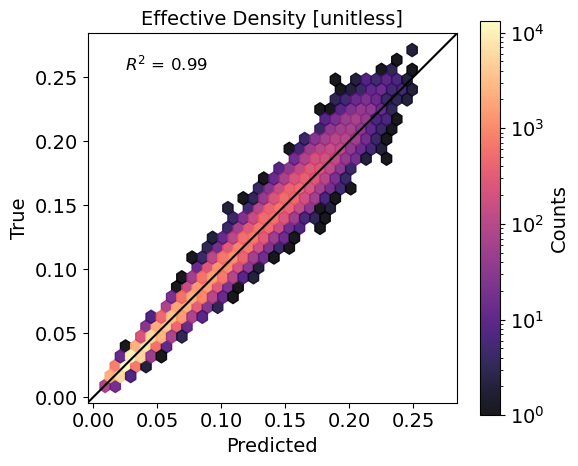

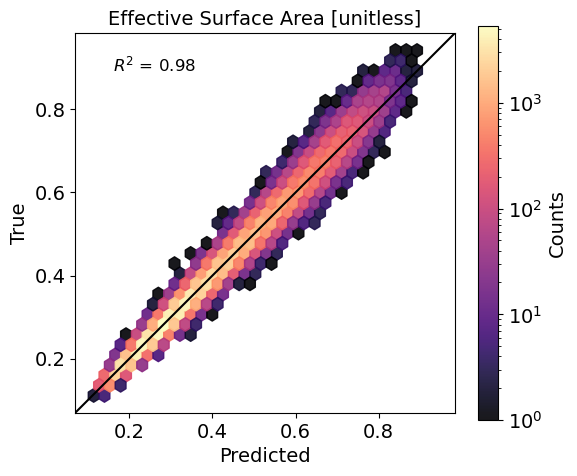

In [70]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    rho_pred, rho_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'resnet18_reg_default_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    sa_pred, sa_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'resnet18_reg_default_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

### Classification

In [71]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'single_view_h5'
input_channels = 1
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)
dm = SingleViewDataModule(
    hdf_file=hdf_path1,
    target_names=targets_cls,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='classification',
    class_to_idx=class_to_idx
)
dm.setup()

In [72]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-classification-subset-700k-csv/version_1/checkpoints/model-epoch=32-val_loss=0.2860.ckpt'
model = ResNet18Classification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=1, 
    num_classes=7, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

/home/jko/miniconda3/envs/torch-v100/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18Classification(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [73]:
loader = dm.test_dataloader()
all_preds = []
all_probs = []
all_targets = []
print_frq = 100
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Get probabilities using softmax
        probs = torch.softmax(preds, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
all_preds = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [74]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(all_targets, all_preds, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
balanced_acc = float(balanced_accuracy_score(all_targets, all_preds))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(all_targets, all_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['resnet18_default'] = metrics
print(metrics)

[0.9058854253371521, 0.9065151760459425, 0.9061141539047604, 0.9064544041972707, 0.9997809544671004]


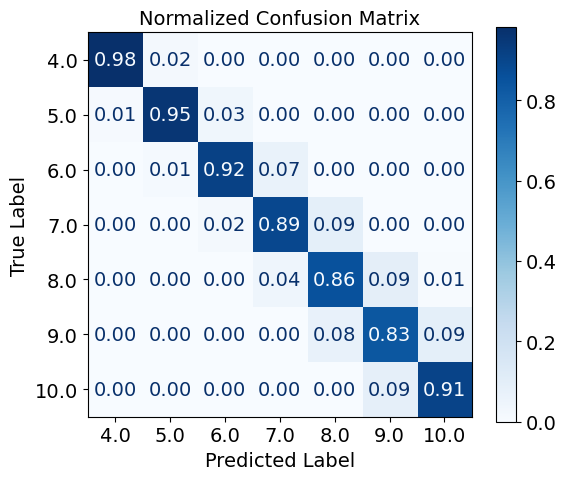

In [75]:
# Extract predictions and targets
preds = all_targets
targets = all_preds

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = list(dm.class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'resnet18_cls_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

## Stereo (2DS)

### Regression

In [76]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = StereoViewDataModule(
    hdf_file_left=hdf_path1,
    hdf_file_right=hdf_path2,
    target_names=targets_reg,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='regression',
    class_to_idx=None
)
dm.setup()

In [77]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-regression-stereo-2ds-subset-700k-csv/version_6/checkpoints/model-epoch=48-val_loss=0.0014.ckpt'
model = ResNet18Regression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=2, 
    output_size=2, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ResNet18Regression(
  (resnet): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [78]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [79]:
# compute metrics and save
rho_true = all_targets[:, 0]
rho_pred = all_preds[:, 0]
sa_true = all_targets[:, 1]
sa_pred = all_preds[:, 1]
# Compute RMSE
rmse_rho = float(np.sqrt(mean_squared_error(rho_true, rho_pred)))
print("RMSE for rho_eff:", rmse_rho)
rmse_sa = float(np.sqrt(mean_squared_error(sa_true, sa_pred)))
print("RMSE for sa_eff:", rmse_sa)
# Compute MAE
mae_rho = float(np.sqrt(mean_absolute_error(rho_true, rho_pred)))
print("MAE for rho_eff:", mae_rho)
mae_sa = float(np.sqrt(mean_absolute_error(sa_true, sa_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(rho_true, rho_pred)
r2_sa = r2_score(sa_true, sa_pred)
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['resnet18_stereo_2ds'] = metrics

RMSE for rho_eff: 0.0028397990417986787
RMSE for sa_eff: 0.01118850252793249
MAE for rho_eff: 0.042157653896031606
MAE for sa_eff: 0.08871854150686459
R2 for effective density = 0.9959685802459717
R2 for effective surface area = 0.9941235184669495


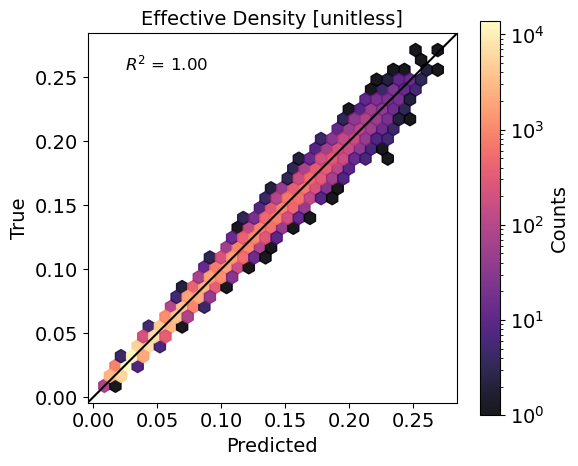

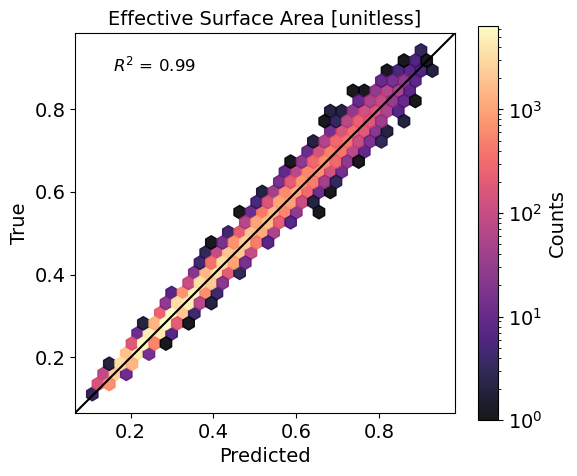

In [80]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    rho_pred, rho_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'resnet18_reg_stereo_2ds_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    sa_pred, sa_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'resnet18_reg_stereo_2ds_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

### Classification

In [81]:
# load data module
second_view = '2ds'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)
dm = StereoViewDataModule(
    hdf_file_left=hdf_path1,
    hdf_file_right=hdf_path2,
    target_names=targets_cls,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='classification',
    class_to_idx=class_to_idx
)
dm.setup()

In [82]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-classification-stereo-2ds-subset-700k-csv/version_2/checkpoints/model-epoch=46-val_loss=0.1057.ckpt'
model = ResNet18Classification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=2, 
    num_classes=7, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

/home/jko/miniconda3/envs/torch-v100/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18Classification(
  (resnet18): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [83]:
loader = dm.test_dataloader()
all_preds = []
all_probs = []
all_targets = []
print_frq = 100
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Get probabilities using softmax
        probs = torch.softmax(preds, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
all_preds = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [84]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(all_targets, all_preds, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
balanced_acc = float(balanced_accuracy_score(all_targets, all_preds))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(all_targets, all_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['resnet18_stereo_2ds'] = metrics
print(metrics)

[0.9781737797716885, 0.9778859248959534, 0.9779159848541072, 0.977836527875614, 1.0]


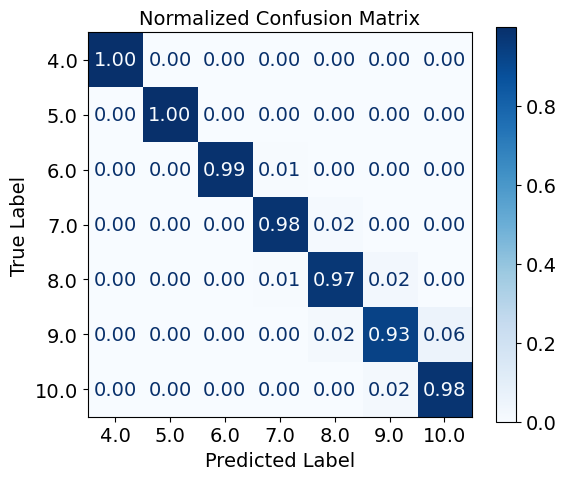

In [85]:
# Extract predictions and targets
preds = all_targets
targets = all_preds

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = list(dm.class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'resnet18_cls_stereo_2ds_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

## Stereo (PHIPS)

### Regression

In [102]:
# load data module
second_view = 'phips'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)
dm = StereoViewDataModule(
    hdf_file_left=hdf_path1,
    hdf_file_right=hdf_path2,
    target_names=targets_reg,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='regression',
    class_to_idx=None
)
dm.setup()

In [103]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-regression-stereo-phips-subset-700k-csv/version_3/checkpoints/model-epoch=49-val_loss=0.0018.ckpt'
model = ResNet18Regression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=2, 
    output_size=2, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ResNet18Regression(
  (resnet): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [104]:
loader = dm.test_dataloader()
all_preds = []
all_targets = []
# Run inference on the test data and print progress
print_frq = 100
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [105]:
# compute metrics and save
rho_true = all_targets[:, 0]
rho_pred = all_preds[:, 0]
sa_true = all_targets[:, 1]
sa_pred = all_preds[:, 1]
# Compute RMSE
rmse_rho = float(np.sqrt(mean_squared_error(rho_true, rho_pred)))
print("RMSE for rho_eff:", rmse_rho)
rmse_sa = float(np.sqrt(mean_squared_error(sa_true, sa_pred)))
print("RMSE for sa_eff:", rmse_sa)
# Compute MAE
mae_rho = float(np.sqrt(mean_absolute_error(rho_true, rho_pred)))
print("MAE for rho_eff:", mae_rho)
mae_sa = float(np.sqrt(mean_absolute_error(sa_true, sa_pred)))
print("MAE for sa_eff:", mae_sa)

# get score
r2_rho = r2_score(rho_true, rho_pred)
r2_sa = r2_score(sa_true, sa_pred)
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

# save metrics 
metrics = [rmse_rho, rmse_sa, mae_rho, mae_sa, r2_rho, r2_sa]
metrics_reg['resnet18_stereo_phips'] = metrics

RMSE for rho_eff: 0.003243765861523786
RMSE for sa_eff: 0.012387432193141982
MAE for rho_eff: 0.04461928489279347
MAE for sa_eff: 0.09354307763646932
R2 for effective density = 0.9947400093078613
R2 for effective surface area = 0.9927965998649597


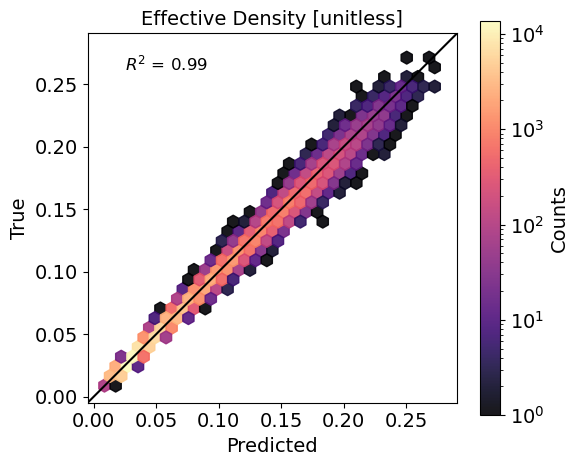

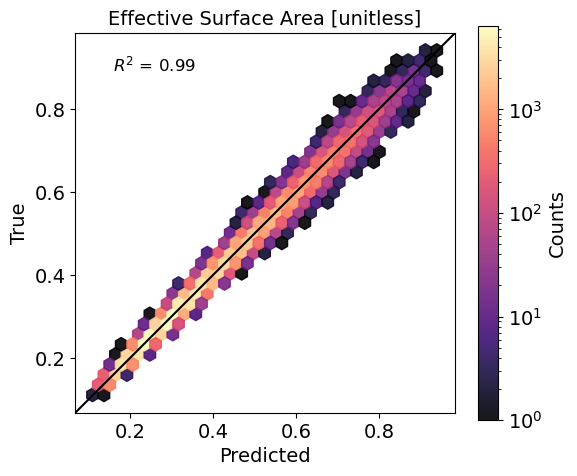

In [106]:
# Plot for rho_eff
fig1, ax1 = plt.subplots(figsize=(6, 5))
hb1 = ax1.hexbin(
    rho_pred, rho_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_rho = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.axline(xy1=(0, 0), slope=1, color='black')
ax1.set_xlim(lims_rho[0], lims_rho[1])
ax1.set_ylim(lims_rho[0], lims_rho[1])
ax1.set_aspect('equal')
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')
ax1.set_title('Effective Density [unitless]')
ax1.text(0.1, 0.9, f'$R^2$ = {r2_rho:.2f}', transform=ax1.transAxes, ha='left', size=12)
cbar1 = fig1.colorbar(hb1, ax=ax1)
cbar1.set_label('Counts')
plt.tight_layout()
savepath1 = os.path.join(savedir, 'resnet18_reg_stereo_phips_scatter_rho.png')
plt.savefig(savepath1, dpi=300)

# Plot for sa_eff
fig2, ax2 = plt.subplots(figsize=(6, 5))
hb2 = ax2.hexbin(
    sa_pred, sa_true,
    gridsize=30, cmap=cmap_reg, mincnt=1, alpha=0.9, bins='log'
)
lims_sa = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.axline(xy1=(0, 0), slope=1, color='black')
ax2.set_xlim(lims_sa[0], lims_sa[1])
ax2.set_ylim(lims_sa[0], lims_sa[1])
ax2.set_aspect('equal')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')
ax2.set_title('Effective Surface Area [unitless]')
ax2.text(0.1, 0.9, f'$R^2$ = {r2_sa:.2f}', transform=ax2.transAxes, ha='left', size=12)
cbar2 = fig2.colorbar(hb2, ax=ax2)
cbar2.set_label('Counts')
plt.tight_layout()
savepath2 = os.path.join(savedir, 'resnet18_reg_stereo_phips_scatter_sa.png')
plt.savefig(savepath2, dpi=300)

### Classification

In [90]:
# load data module
second_view = 'phips'
hdf_dir = '/home/jko/synth-ros-data/imgs-ml-ready/shuffled_small'
hdf_file1 = 'default_shuffled_small.h5'
hdf_file2 = f'{second_view}_shuffled_small.h5'
hdf_path1 = os.path.join(hdf_dir, hdf_file1)
hdf_path2 = os.path.join(hdf_dir, hdf_file2)
data_type = 'stereo_view_h5'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)
dm = StereoViewDataModule(
    hdf_file_left=hdf_path1,
    hdf_file_right=hdf_path2,
    target_names=targets_cls,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=None,
    subset_seed=n_rand,
    num_workers=16,
    prefetch_factor=16,
    train_transform=transforms['train'],
    val_transform=transforms['val'],
    test_transform=transforms['test'],
    train_target_transform=transforms['train_target'],
    val_target_transform=transforms['val_target'],
    test_target_transform=transforms['test_target'],
    task_type='classification',
    class_to_idx=class_to_idx
)
dm.setup()

In [91]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/resnet18-classification-stereo-phips-subset-700k-csv/version_1/checkpoints/model-epoch=48-val_loss=0.1919.ckpt'
model = ResNet18Classification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_channels=2, 
    num_classes=7, 
    learning_rate=1e-3, 
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

/home/jko/miniconda3/envs/torch-v100/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18Classification(
  (resnet18): ResNet(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [92]:
loader = dm.test_dataloader()
all_preds = []
all_probs = []
all_targets = []
print_frq = 100
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(loader)
    for i, batch in enumerate(loader):
        if i % print_frq == 0:
            print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Get probabilities using softmax
        probs = torch.softmax(preds, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
all_preds = np.argmax(all_preds, axis=1)

Processing batch 1 out of 821...
Processing batch 101 out of 821...
Processing batch 201 out of 821...
Processing batch 301 out of 821...
Processing batch 401 out of 821...
Processing batch 501 out of 821...
Processing batch 601 out of 821...
Processing batch 701 out of 821...
Processing batch 801 out of 821...


In [93]:
# compute and save metrics

# Assume y_true and y_test_pred are your numpy arrays
# For top-k accuracy, y_test_pred_proba should be the predicted probabilities (shape: [n_samples, n_classes])

# Binary or multiclass labels
precision = precision_score(all_targets, all_preds, average='weighted')  # or 'macro', 'micro', 'binary'
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
balanced_acc = float(balanced_accuracy_score(all_targets, all_preds))

# For top-k accuracy (e.g., k=3)
# y_test_probs: shape (n_samples, n_classes)
top_k = float(top_k_accuracy_score(all_targets, all_probs, k=3))

# collect and save metrics
metrics = [precision, recall, f1, balanced_acc, top_k]
metrics_cls['resnet18_stereo_phips'] = metrics
print(metrics)

[0.953981537720499, 0.9540766278416396, 0.9539959244528381, 0.9540127377033292, 0.9999809525623565]


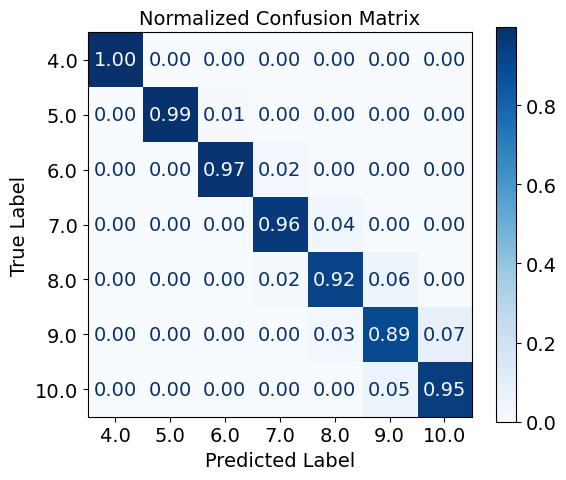

In [94]:
# Extract predictions and targets
preds = all_targets
targets = all_preds

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = list(dm.class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap=cmap_cls, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
# save plot
savepath = os.path.join(savedir, 'resnet18_cls_stereo_phips_cm.png')
plt.savefig(savepath, dpi=300)
plt.show()

# Save metrics

In [107]:
print('=== regression metrics ===')
print(metrics_reg)
print('=== classification metrics ===')
print(metrics_cls)

=== regression metrics ===
{'lin_stereo_2ds': [0.009627732215741244, 0.03322123272920497, 0.08373955742513928, 0.15933996505329268, 0.9536625352117107, 0.9481908234403171], 'lin_stereo_phips': [0.009921519516915235, 0.035027940693077284, 0.08509859521049697, 0.1641290584376654, 0.9507914411366686, 0.9424023964837196], 'rf_default': [0.009677788325068283, 0.040968963443442925, 0.08032469636408379, 0.17588820603944488, 0.9531794509700415, 0.9212074502656921], 'mlp_default': [0.009557838378355832, 0.04066638191453557, 0.07964097761678965, 0.17522652304443667, 0.9543328881263733, 0.9223670363426208], 'cnn_default': [0.007281479211969412, 0.028530341957358634, 0.068935919383856, 0.14529714118636952, 0.9734952449798584, 0.9617889523506165], 'resnet18_default': [0.004753214779918458, 0.018600166575032984, 0.05479987978494599, 0.11506984166169364, 0.9887056946754456, 0.9837591648101807], 'resnet18_stereo_2ds': [0.0028397990417986787, 0.01118850252793249, 0.042157653896031606, 0.088718541506864

In [108]:
# Convert to DataFrames
regression_df = pd.DataFrame(
    [(k, *v) for k, v in metrics_reg.items()],
    columns=['model', 'rmse_rho', 'rmse_sa', 'mae_rho', 'mae_sa', 'r2_rho', 'r2_sa']
)

classification_df = pd.DataFrame(
    [(k, *v) for k, v in metrics_cls.items()],
    columns=['model', 'precision', 'recall', 'f1', 'balanced_acc', 'top_k']
)

In [109]:
# save metrics as csv files
metrics_dir = './metrics'
os.makedirs(metrics_dir, exist_ok=True)
metrics_reg_path = os.path.join(metrics_dir, 'metrics_reg.csv')
metrics_cls_path = os.path.join(metrics_dir, 'metrics_cls.csv')
regression_df.to_csv(metrics_reg_path, index=False)
classification_df.to_csv(metrics_cls_path, index=False)

In [110]:
# load csv to test 
metrics_dir = './metrics'
metrics_reg_path = os.path.join(metrics_dir, 'metrics_reg.csv')
metrics_cls_path = os.path.join(metrics_dir, 'metrics_cls.csv')
df_reg = pd.read_csv(metrics_reg_path)
df_cls = pd.read_csv(metrics_cls_path)

In [111]:
df_reg

,model,rmse_rho,rmse_sa,mae_rho,mae_sa,r2_rho,r2_sa
0,lin_stereo_2ds,0.009628,0.033221,0.083740,0.159340,0.953663,0.948191
1,lin_stereo_phips,0.009922,0.035028,0.085099,0.164129,0.950791,0.942402
2,rf_default,0.009678,0.040969,0.080325,0.175888,0.953179,0.921207
3,mlp_default,0.009558,0.040666,0.079641,0.175227,0.954333,0.922367
4,cnn_default,0.007281,0.028530,0.068936,0.145297,0.973495,0.961789
5,resnet18_default,0.004753,0.018600,0.054800,0.115070,0.988706,0.983759
6,resnet18_stereo_2ds,0.002840,0.011189,0.042158,0.088719,0.995969,0.994124
7,resnet18_stereo_phips,0.003244,0.012387,0.044619,0.093543,0.994740,0.992797


In [112]:
df_cls

,model,precision,recall,f1,balanced_acc,top_k
0,lin_default,0.447550,0.453510,0.449689,0.453500,0.901744
1,lin_stereo_2ds,0.582324,0.584499,0.583282,0.584439,0.971457
2,lin_stereo_phips,0.563955,0.568433,0.565748,0.568382,0.967134
3,rf_default,0.450301,0.460386,0.452991,0.460386,0.904944
4,mlp_default,0.461241,0.468786,0.463523,0.468773,0.908810
5,cnn_default,0.768904,0.764021,0.764254,0.763856,0.997019
6,resnet18_default,0.905885,0.906515,0.906114,0.906454,0.999781
7,resnet18_stereo_2ds,0.978174,0.977886,0.977916,0.977837,1.000000
8,resnet18_stereo_phips,0.953982,0.954077,0.953996,0.954013,0.999981
